In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm

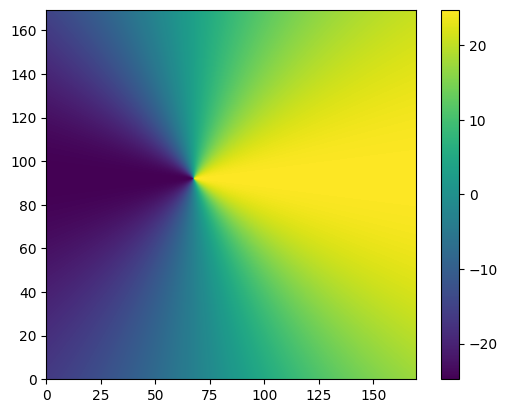

In [21]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.2, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678      # numebr of pixels per axis
pixscale = 0.25
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)

alpha_x_2d *=pixscale
alpha_y_2d *=pixscale

plt.imshow(alpha_x_2d, extent=[0, size*pixscale, 0, size*pixscale])
plt.colorbar()

alpha_x_2d /=pixscale      # back to pixel for convenience
alpha_y_2d /=pixscale

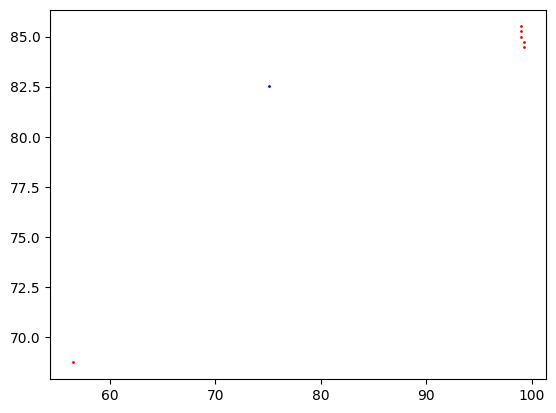

In [22]:
coord = (300.3,330.2) #in pixel
def find_rough_def_pix(coord):    # data are in pixel
    coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
    y_round, x_round = round(coord[1]), round(coord[0])

    # Pre-calculate possible matching rounded values for efficiency
    y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
    x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

    coordinates = []
    n = 0

    # Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
    for i in range(size):
        for j in range(size):
            ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
            if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
                coordinates.append((j, i))  # (x, y)
                n += 1
    
    plt.scatter([i[0]*pixscale for i in coordinates], [i[1]*pixscale for i in coordinates], c='r', s=1)
    plt.scatter(coord[0]*pixscale, coord[1]*pixscale, c='b', s=1)
    
    return coordinates
coordinates = find_rough_def_pix(coord)  #in pixel



Number of pixels: [1, 5]


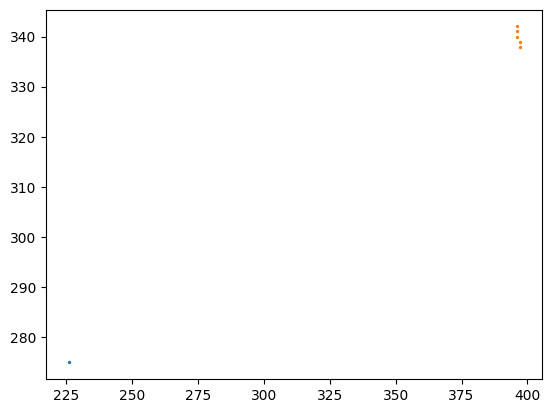

In [23]:
coordinates = np.array(coordinates) #data in pixel

#DBSCAN clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=1).fit(coordinates)
labels = dbscan.labels_
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=2)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')


In [24]:
# interpolate the deflected angle given the image pos
def def_angle_test_interpolate(x,y, alpha_x= alpha_x_2d, alpha_y = alpha_y_2d):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_guess = np.array([x-alpha[0], y-alpha[1]])
    return src_guess, alpha
                                             
def diff_interpolate (img_guess):
    src_guess = def_angle_test_interpolate(img_guess[0],img_guess[1])[0]
    return np.sqrt((src_guess[0]-coord[0])**2 + (src_guess[1]-coord[1])**2)



56.5 56.5 68.75 68.75 [56.58188934 68.72201445] 2.2482741429069575e-09
99.0 99.25 84.5 85.5 [99.12951014 85.27141602] 1.9590791423977473e-09


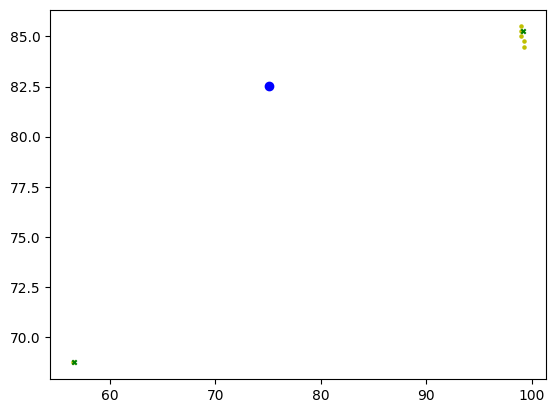

In [25]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0]*pixscale, coord[1]*pixscale, c='b')
plt.scatter([i[0]*pixscale for i in coordinates], [i[1]*pixscale for i in coordinates], c='y', s=5)
img = [[] for _ in range(len(images))]
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min*pixscale, x_max*pixscale, y_min*pixscale, y_max*pixscale, pos.x*pixscale, diff_interpolate(pos.x))
    plt.scatter(pos.x[0]*pixscale, pos.x[1]*pixscale, c='g', s=10, marker='x')
    img[i] = (pos.x[0]* pixscale, pos.x[1]*pixscale)
    

#pos still in pix

In [26]:
# make deflections in arcsec scale
alpha_x_2d_arc = alpha_x_2d*pixscale
alpha_y_2d_arc = alpha_y_2d*pixscale


# magnification and time delay given source and image positions
image_position = np.array([292.20972091, 424.95360024]) #in pixel
mag1 = lensModel.magnification(image_position[0], image_position[1], kwargs_lens)
print(f"Analytical magnification : {mag1}")
def calculate_magnification(theta, h=1e-9):
    """
    Calculate the magnification at a given image position theta.
    
    :param theta: Image position (2D numpy array)
    :param h: Step size for numerical differentiation
    :return: Magnification
    """
    # Compute partial derivatives

    def partial_derivative(func, var, point): 
        args = point[:]
        def wraps(x):
            args[var] = x
            return func(args)
        return lambda x: (wraps(x+h) - wraps(x-h))/(2*h) # central difference diff fct
  
    
    def alpha(t):
        alpha = def_angle_test_interpolate(t[0], t[1])[1]
        a = float(f"{alpha[0]:.12f}")
        b = float(f"{alpha[1]:.12f}")
        return np.array([a, b])

    dalpha1_dtheta1 = partial_derivative(lambda t: alpha(t)[0], 0, theta)(theta[0])
    dalpha1_dtheta2 = partial_derivative(lambda t: alpha(t)[0], 1, theta)(theta[1])
    dalpha2_dtheta1 = partial_derivative(lambda t: alpha(t)[1], 0, theta)(theta[0])
    dalpha2_dtheta2 = partial_derivative(lambda t: alpha(t)[1], 1, theta)(theta[1])
    # Construct the magnification tensor
    A = np.array([
        [1 - dalpha1_dtheta1, -dalpha1_dtheta2],
        [-dalpha2_dtheta1, 1 - dalpha2_dtheta2]
    ])
    
    # Calculate magnification
    magnification = 1 / np.linalg.det(A)
    
    return magnification

# Example usage

mag = calculate_magnification(image_position)
image_position_arc = image_position*pixscale
print(f"Interpolation magnification at {image_position*pixscale}: {mag}")



Analytical magnification : 8.826108505221894
Interpolation magnification at [ 73.05243023 106.23840006]: 8.853050779671683


image (56.58188934116531, 68.7220144461648):
Analytical Fermat potential : 137.28350902833492
Analytical lens potential : 129.32065413015513
image (99.12951014356315, 85.27141602062653):
Analytical Fermat potential : -19.780764529365058
Analytical lens potential : 312.7935462314176


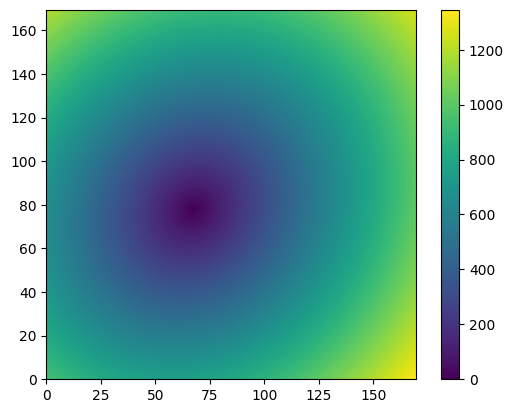

In [27]:
# time delay by diff of fermat potentials
kwargs_sie = {'theta_E': 10, 'e1':0, 'e2':0.2, 'center_x': 270*pixscale, 'center_y': 310*pixscale} #in arcsec
kwargs_lens = [kwargs_sie]

theta = img  #in arcsec

beta = (coord[0]*pixscale, coord[1]*pixscale) #in arcsec
for i in range(len(theta)):
    fermat_analytical = lensModel.fermat_potential(theta[i][0],theta[i][1], kwargs_lens,beta[0],beta[1])
    psi = lensModel.potential(theta[i][0], theta[i][1], kwargs_lens) # fermat = (theta-beta)^2/2 - psi
    print(f"image {theta[i]}:")
    print(f"Analytical Fermat potential : {fermat_analytical}")
    print(f"Analytical lens potential : {psi}")
 
 
# get fermat potential from interpolation and psi map only (psi is lens potential)
x_flat_arc = x_flat*pixscale
y_flat_arc = y_flat*pixscale
psi = lensModel.potential(x_flat_arc, y_flat_arc, kwargs_lens)
psi_2d = psi.reshape(x_grid.shape) #(y,x)
plt.imshow(psi_2d, extent=[0, size*pixscale, size*pixscale,0]) #psi in arcsec but with 678*678 array
plt.gca().invert_yaxis()
plt.colorbar()


In [28]:
def psi_interpolate(x,y, psi = psi_2d):  #(x,y) is img_guess
    x = x/pixscale
    y = y/pixscale
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array(psi[ceil(y), floor(x)]) #to match (y,x) of alpha grid
    top_right = np.array(psi[ceil(y), ceil(x)])
    bottom_left = np.array(psi[floor(y), floor(x)])
    bottom_right = np.array(psi[floor(y), ceil(x)])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    psi = top * dy + bottom *(1 - dy)
    return psi

def fermat_potential(theta, beta):
    return 0.5 * (np.linalg.norm(theta - beta)**2) - psi_interpolate(theta[0], theta[1])

for i in range(len(theta)):
    print(f"Interpolation Fermat potential at {theta[i]}: {fermat_potential(np.array(theta[i]), beta)}")

# time delay by diff of fermat potentials and scale it by time-delay distance
dt = []
for i in range(len(theta)):
    dt.append(fermat_potential(np.array(theta[i]), beta) - fermat_potential(np.array(theta[0]), beta))
    print(f"demensionless time delay at {theta[i]}: {dt[i]}")


Interpolation Fermat potential at (56.58188934116531, 68.7220144461648): 137.27952754467663
Interpolation Fermat potential at (99.12951014356315, 85.27141602062653): -19.78165976466346
demensionless time delay at (56.58188934116531, 68.7220144461648): 0.0
demensionless time delay at (99.12951014356315, 85.27141602062653): -157.06118730934008


In [29]:

from astropy.cosmology import FlatLambdaCDM
import lenstronomy.Util.constants as const

# Redshifts
z_L = 0.5
z_S = 1.0

# Calculate distances
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_L = cosmo.angular_diameter_distance(z_L)
D_S = cosmo.angular_diameter_distance(z_S)
D_LS = cosmo.angular_diameter_distance_z1z2(z_L, z_S)
#print(D_LS)
time_delay_distance = (1 + z_L) * D_L * D_S / D_LS * const.Mpc
print(f"Time-delay distance: {time_delay_distance.value}")
dt_days = np.array(dt) * time_delay_distance.value / const.c / const.day_s * const.arcsec ** 2
print(f"Numerical time delay in days: {dt_days} days")


Time-delay distance: 1.3604890145694932e+26
Numerical time delay in days: [     0.        -19390.0622704] days


In [30]:
# analytical time delay by lenstronomy

from lenstronomy.Cosmo.lens_cosmo import LensCosmo


# Set up cosmology


# Define lens and source redshifts
z_lens = 0.5
z_source = 1.0


# Define source position
source_x, source_y = beta[0], beta[1]  # arcsec
print(source_x, source_y)
# Solve lens equation to find image positions

# print(img)# arcsec

# Set up LensCosmo for time delay calculation
lensCosmo = LensCosmo(z_lens, z_source, cosmo)

# Calculate Fermat potential for each image
fermat_pot = []
for i in range(len(img)):
    fermat_pot.append(lensModel.fermat_potential(img[i][0], img[i][1], kwargs_lens))
# Calculate relative time delays
t_days = []
for i in range(len(fermat_pot)):
    dt = lensCosmo.time_delay_units(fermat_pot[i] - fermat_pot[0])
    dfishball = fermat_pot[i] - fermat_pot[0]
    t_days.append(dt)
print(t_days)


75.075 82.55
[0.0, -22129.381842332965]
